<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depth Anything V1
Paper: https://arxiv.org/pdf/2401.10891.pdf

In [1]:
!gdown 1L3mKl7qlUGE47wZydUST2aTXlBKpN-oI

Downloading...
From: https://drive.google.com/uc?id=1L3mKl7qlUGE47wZydUST2aTXlBKpN-oI
To: /content/img.png
100% 1.55M/1.55M [00:00<00:00, 76.7MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.6 MB/s eta 0:00:00


raw input (720, 1280)
raw input (720, 1280) inputs torch.Size([1, 3, 518, 924]) predicted_depth torch.Size([1, 518, 924])
Original model train on the scale of 0 to 30
prediction: min scale = 0.0 max scale= 162.75508


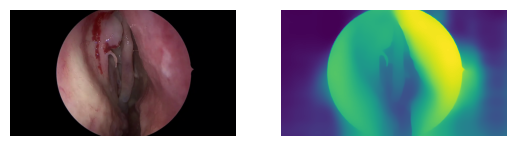

In [6]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

# url = "img.png"
url = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
image = Image.open(url).convert("RGB")

# image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
# model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);
da_v1 = depth

#Depth and Reconstruction

raw input (720, 1280) inputs torch.Size([1, 3, 518, 924]) predicted_depth torch.Size([1, 518, 924])
upsampled predicted_depth: (720, 1280)
Original model train on the scale of 0 to 30
prediction: min scale = 0.0 max scale= 157.19305
formatted: min scale = 0 max scale= 255


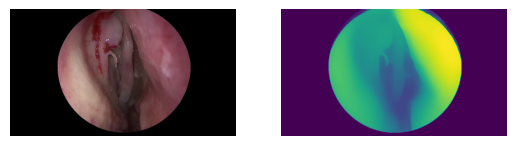

In [75]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from glob import glob
import cv2

def img_to_mask(img, reduction=40):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print(np.unique(img_gray))
    mask = np.zeros(img_gray.shape)
    mask_final = np.zeros(mask.shape)
    mask[img_gray>0] = 255
    #print(np.unique(mask), mask.shape)
    mask = np.array(mask, np.uint8)
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 3.5, 100)
    if circles is not None:
        #print('found')
        circles = np.round(circles[0, :]).astype("int")
        (x, y, r) = circles[0:1][0]
        cv2.circle(mask_final, (x, y), r-reduction, 1, -1)
        img[mask_final==0] = 0
    else: print('not found:')
    return mask_final
#imgs_all = glob("/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/*.png")
url = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
image = Image.open(url).convert("RGB")
image_np = np.array(image)
mask = img_to_mask(image_np)
image_np[mask==0] = 0
image = Image.fromarray(image_np)

inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth


print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()

#interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()
output[mask==0] = 0
print('upsampled predicted_depth:', output.shape)

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
print('formatted: min scale =', formatted.min(), 'max scale=', formatted.max())
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);

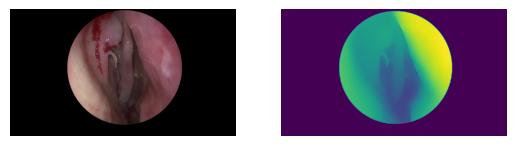

In [90]:
def img_to_mask(img, reduction=40):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print(np.unique(img_gray))
    mask = np.zeros(img_gray.shape)
    mask_final = np.zeros(mask.shape)
    mask[img_gray>0] = 255
    #print(np.unique(mask), mask.shape)
    mask = np.array(mask, np.uint8)
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 3.5, 100)
    if circles is not None:
        #print('found')
        circles = np.round(circles[0, :]).astype("int")
        (x, y, r) = circles[0:1][0]
        cv2.circle(mask_final, (x, y), r-reduction, 1, -1)
        img[mask_final==0] = 0
    else: print('not found:')
    return mask_final

output = prediction.squeeze().cpu().numpy()
image_np = np.array(image)
mask = img_to_mask(image_np, reduction=45)
image_np[mask==0] = 0
output[mask==0] = 0

plt.subplot(121),plt.axis('OFF'),plt.imshow(image_np)
plt.subplot(122),plt.axis('OFF'),plt.imshow(output);

(720, 1280) 0.001 157.19072
(720, 1280) 0.001 157.19072
(720, 1280) 0.001 157.19072


True

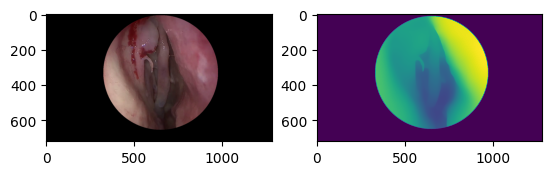

In [92]:
import matplotlib
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib as mpl
import matplotlib.cm as cm

def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

def render_depth_v2(values, colormap_name="magma_r") -> Image:
    vmax = np.percentile(values, 95)
    normalizer = mpl.colors.Normalize(vmin=values.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(values)[:, :, :3] * 255).astype(np.uint8)
    return Image.fromarray(colormapped_im)

def reconstruct_pointcloud(rgb, depth, cam_K, vis_rgbd=False):

    rgb = np.asarray(rgb, order="C")
    rgb_im = o3d.geometry.Image(rgb.astype(np.uint8))
    depth_im = o3d.geometry.Image(depth)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_im, depth_im, convert_rgb_to_intensity=False)
    if vis_rgbd:
        plt.subplot(1, 2, 1)
        plt.title('RGB image')
        plt.imshow(rgbd_image.color)
        plt.subplot(1, 2, 2)
        plt.title('Depth image')
        plt.imshow(rgbd_image.depth)
        plt.colorbar()
        plt.show()

    cam = o3d.camera.PinholeCameraIntrinsic()
    cam.intrinsic_matrix = cam_K

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        cam
    )

    return pcd


# fx = 850.709
fx = 1050.709
img_width =  1280
img_height = 720
intrinsics = np.array([[fx / img_width, 0, 0.5, 0],
                   [0, fx / img_height, 0.5, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

intrinsics[0,:] *= img_width
intrinsics[1,:] *= img_height
cam_K = intrinsics[:3,:3]
# vis_pred_depth = render_depth(output/255)
vis_pred_depth = render_depth_v2(output/255)
vis_file_name = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086_v2.png"
vis_pred_depth.save(vis_file_name)

pred_depth = output
print(pred_depth.shape, pred_depth.min(), pred_depth.max())
scale = 1 #200
MIN_DEPTH = 1e-3
MAX_DEPTH = 200
pred_depth *= scale
print(pred_depth.shape, pred_depth.min(), pred_depth.max())

pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
plt.subplot(122); plt.imshow(pred_depth)
plt.subplot(121); plt.imshow(image_np)

# pred_depth[mask==0] = 0
print(pred_depth.shape, pred_depth.min(), pred_depth.max())
pcd = reconstruct_pointcloud(image_np, pred_depth, cam_K, vis_rgbd=False)
ply_file_dir = '/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/PLY_DA_Large/0000086_v2.ply'
o3d.io.write_point_cloud(ply_file_dir, pcd)

#Depth and Reconstruction: All Together

In [15]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from glob import glob
import matplotlib
import open3d as o3d
import cv2
import matplotlib as mpl
import matplotlib.cm as cm
import os

def render_depth_v2(values, colormap_name="magma_r") -> Image:
    vmax = np.percentile(values, 95)
    normalizer = mpl.colors.Normalize(vmin=values.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(values)[:, :, :3] * 255).astype(np.uint8)
    return Image.fromarray(colormapped_im)

def reconstruct_pointcloud(rgb, depth, cam_K, vis_rgbd=False):

    rgb = np.asarray(rgb, order="C")
    rgb_im = o3d.geometry.Image(rgb.astype(np.uint8))
    depth_im = o3d.geometry.Image(depth)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_im, depth_im, convert_rgb_to_intensity=False)
    if vis_rgbd:
        plt.subplot(1, 2, 1)
        plt.title('RGB image')
        plt.imshow(rgbd_image.color)
        plt.subplot(1, 2, 2)
        plt.title('Depth image')
        plt.imshow(rgbd_image.depth)
        plt.colorbar()
        plt.show()

    cam = o3d.camera.PinholeCameraIntrinsic()
    cam.intrinsic_matrix = cam_K
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam)

    return pcd

def reconstruct_pointcloud_write(pred_depth, img_np, cam_K, ply_dir=None):

    scale = 1 #200
    MIN_DEPTH = 1e-3
    MAX_DEPTH = 400
    pred_depth *= scale
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    print('Final depth min:',pred_depth.min(), ', max:', pred_depth.max())
    pcd = reconstruct_pointcloud(img_np, pred_depth, cam_K, vis_rgbd=False)
    o3d.io.write_point_cloud(ply_dir, pcd)
    print('3D Recon .ply saved in:', ply_dir)

def img_to_mask(img, reduction=40):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print(np.unique(img_gray))
    mask = np.zeros(img_gray.shape)
    mask_final = np.zeros(mask.shape)
    mask[img_gray>0] = 255
    #print(np.unique(mask), mask.shape)
    mask = np.array(mask, np.uint8)
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 3.5, 100)
    if circles is not None:
        #print('found')
        circles = np.round(circles[0, :]).astype("int")
        (x, y, r) = circles[0:1][0]
        cv2.circle(mask_final, (x, y), r-reduction, 1, -1)
        img[mask_final==0] = 0
    else: print('not found:')
    return mask_final

def depth_prediction(img, image_processor, model):
    inputs = image_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth


    # print('raw input', img.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
    prediction = predicted_depth.clone()

    #interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    output = prediction.squeeze().cpu().numpy()
    return output


device = 'cuda' if torch.cuda.is_available() else 'cpu'
fx = 850.709
# fx = 1050.709
img_width =  1280
img_height = 720
intrinsics = np.array([[fx / img_width, 0, 0.5, 0],
                [0, fx / img_height, 0.5, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

intrinsics[0,:] *= img_width
intrinsics[1,:] *= img_height
cam_K = intrinsics[:3,:3]

# image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
# model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf").to(device)
# model_weights = 'DA1_SMALL'

# image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
# model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf").to(device)
# model_weights = 'DA1_LARGE'

# image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
# model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to(device)
# model_weights = 'DA2_SMALL'

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)
model_weights = 'DA2_LARGE'

recon_dir = "/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/{}/PLY".format(model_weights)
depth_dir = "/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/{}/Depth_Pred".format(model_weights)
imgs_dirs = glob("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/imgs/*.png")
masked_imgs_dirs = "/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/masked_imgs"
os.makedirs(recon_dir, mode = 0o777, exist_ok = True)
os.makedirs(depth_dir, mode = 0o777, exist_ok = True)
os.makedirs(masked_imgs_dirs, mode = 0o777, exist_ok = True)

for img_dir in imgs_dirs:
    img = Image.open(img_dir).convert("RGB")
    img_np = np.array(img)
    mask = img_to_mask(img_np, reduction=35)
    img_np[mask==0] = 0
    img = Image.fromarray(img_np)
    output = depth_prediction(img, image_processor, model)
    mask = img_to_mask(img_np, reduction=40)
    img_np[mask==0] = 0
    output[mask==0] = 0
    Image.fromarray(img_np).save(img_dir.replace('imgs', 'masked_imgs'))
    vis_pred_depth = render_depth_v2(output/255)
    file_name = os.path.basename(img_dir)
    vis_pred_depth.save(os.path.join(depth_dir, file_name))
    reconstruct_pointcloud_write(output, img_np, cam_K, ply_dir=os.path.join(recon_dir, file_name[:-3]+'ply'))


Final depth min: 0.001 , max: 333.29272
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000097.ply
Final depth min: 0.001 , max: 342.09692
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000099.ply
Final depth min: 0.001 , max: 400.0
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000098.ply
Final depth min: 0.001 , max: 307.63965
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000107.ply
Final depth min: 0.001 , max: 313.8575
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000501.ply
Final depth min: 0.001 , max: 332.1712
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/PLY/0000535.ply
Final depth min: 0.001 , max: 356.7084
3D Recon .ply saved in: /content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_

This code produce too small recon

In [19]:
import open3d as o3d
import numpy as np

# Load depth image (replace 'depth_image.png' with your actual file path)
depth_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/Depth_Pred/0004502.png")

# Define camera intrinsics (replace with your actual values)
width = 1280  # Example width
height = 720  # Example height
fx = 850.709  # Example focal length x
fy = 850.709  # Example focal length y
cx = 640  # Example principal point x
cy = 360  # Example principal point y
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# Create RGBD image from depth and color (if available)
color_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/masked_imgs/0004502.png")  # Optional, if you have a color image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_image, depth_image, depth_scale=1000.0, depth_trunc=3.0, convert_rgb_to_intensity=False
)

# Create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)

ply_dir = "/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/0004502.ply"
o3d.io.write_point_cloud(ply_dir, pcd)
# Visualize point cloud
# o3d.visualization.draw_geometries([pcd])

True

Scale is good but truncate a lot

In [39]:
import open3d as o3d
import numpy as np

# Load the depth image (16-bit PNG, assumed to be in millimeters or meters)
depth_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/Depth_Pred/0004502.png")
print(np.array(depth_image).min(), np.array(depth_image).max())
# Load the RGB image
color_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/masked_imgs/0004502.png")

# Ensure the depth image is in the correct format (convert if needed)
depth_image_np = np.asarray(depth_image)
if depth_image_np.dtype != np.float32:
    depth_image_np = depth_image_np.astype(np.float32) / 100.0  # Convert from mm to meters if needed
    depth_image = o3d.geometry.Image(depth_image_np)
    print('if inside:',np.array(depth_image).min(), np.array(depth_image).max())


# Create an RGBD image from the color and depth images
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_image, depth_image, convert_rgb_to_intensity=False, depth_scale=1.0, depth_trunc=3.0
)

# Define the camera intrinsic parameters
fx = 850.709  # focal length x
fy = 850.709  # focal length y
cx = 640  # principal point x
cy = 360  # principal point y
width = 1280
height = 720

# Create Open3D intrinsic object
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# Create the point cloud from the RGBD image
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, intrinsic
)

# Flip the point cloud (optional, for better visualization in Open3D's coordinate system)
point_cloud.transform([[1, 0, 0, 0],
                       [0, -1, 0, 0],
                       [0, 0, -1, 0],
                       [0, 0, 0, 1]])

# Optionally, visualize the point cloud
# o3d.visualization.draw_geometries([point_cloud])

# Save the point cloud as a .ply file (with RGB colors)
o3d.io.write_point_cloud("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/0004502v2_2.ply", point_cloud)


0 254
if inside: 0.0 25.4


True

In [43]:
import open3d as o3d
import numpy as np

# Load the depth image (16-bit PNG, assumed to be in millimeters or meters)
depth_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/Depth_Pred/0004502.png")
print(np.array(depth_image).min(), np.array(depth_image).max())

# Load the RGB image
color_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/masked_imgs/0004502.png")

# Ensure the depth image is in the correct format (convert if needed)
depth_image_np = np.asarray(depth_image)
if depth_image_np.dtype != np.float32:
    depth_image_np = depth_image_np.astype(np.float32) / 100.0  # Convert from mm to meters if needed
    depth_image = o3d.geometry.Image(depth_image_np)
    print('if inside:', np.array(depth_image).min(), np.array(depth_image).max())

# Create an RGBD image from the color and depth images
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_image, depth_image, convert_rgb_to_intensity=False, depth_scale=1.0, depth_trunc=3.0
)

# Define the camera intrinsic parameters
fx = 850.709  # focal length x
fy = 850.709  # focal length y
cx = 640  # principal point x
cy = 360  # principal point y
width = 1280
height = 720

# Create Open3D intrinsic object
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# Create the point cloud from the RGBD image
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, intrinsic
)

# Apply a scaling factor to the point cloud to make it bigger
scaling_factor = 10.0  # Adjust this factor to scale the point cloud
point_cloud.scale(scaling_factor, center=point_cloud.get_center())

# Flip the point cloud (optional, for better visualization in Open3D's coordinate system)
point_cloud.transform([[1, 0, 0, 0],
                       [0, -1, 0, 0],
                       [0, 0, -1, 0],
                       [0, 0, 0, 1]])

# Optionally, visualize the point cloud
# o3d.visualization.draw_geometries([point_cloud])

# Save the point cloud as a .ply file (with RGB colors)
o3d.io.write_point_cloud("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/0004502v2_4.ply", point_cloud)


0 254
if inside: 0.0 2.54


True

In [27]:
import open3d as o3d
import numpy as np

# Load depth image (replace 'depth_image.png' with your actual file path)
depth_image = o3d.io.read_image("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/DA2_LARGE/Depth_Pred/0004502.png")
# Convert to grayscale manually if it's a color image
depth_array = np.asarray(depth_image)
if len(depth_array.shape) == 3:  # Check if it has 3 channels (color)
    depth_array = np.mean(depth_array, axis=2)  # Average RGB channels
    depth_image = o3d.geometry.Image(depth_array.astype(np.uint8))
# Define camera intrinsics (replace with your actual values)
width = 1280  # Example width
height = 720  # Example height
fx = 850.709  # Example focal length x
fy = 850.709  # Example focal length y
cx = 640  # Example principal point x
cy = 360  # Example principal point y
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# Create point cloud directly from depth image
depth = np.asarray(depth_image)
xmap = np.arange(width)
ymap = np.arange(height)
xmap, ymap = np.meshgrid(xmap, ymap)

points_z = depth / 1000.0  # Adjust depth scale if necessary
points_x = (xmap - cx) * points_z / fx
points_y = (ymap - cy) * points_z / fy

points = np.stack((points_x, points_y, points_z), axis=-1)
points = points.reshape(-1, 3)

# Create Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.io.write_point_cloud("/content/drive/MyDrive/Datasets_Weights/Endonasal/recon2/0004502v3.ply", pcd)

# Visualize point cloud
# o3d.visualization.draw_geometries([pcd])

True

#Depth Anything V2

raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 0.0 max scale= 218.63155


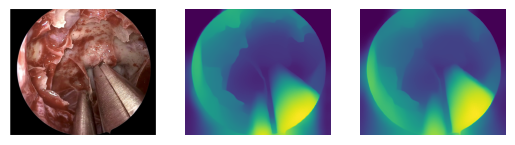

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(131),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(132),plt.axis('OFF'),plt.imshow(depth);
plt.subplot(133),plt.axis('OFF'),plt.imshow(da_v1);

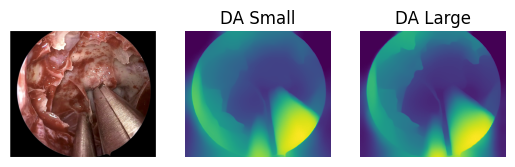

In [ ]:
plt.subplot(131),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(132),plt.axis('OFF'),plt.title('DA Small');plt.imshow(da_v1);
plt.subplot(133),plt.axis('OFF'),plt.title('DA Large');plt.imshow(depth);

raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 0.6620687 max scale= 6.6914554


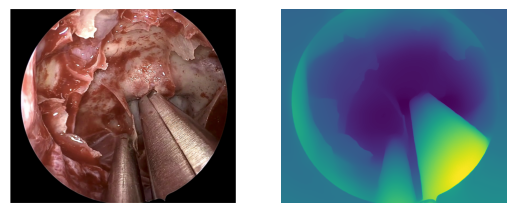

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 28.133162 max scale= 567.1909


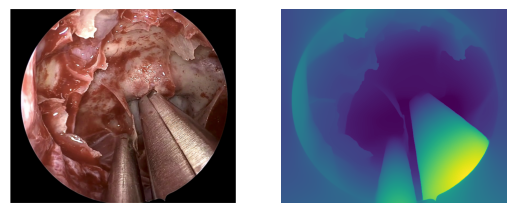

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);